In [1]:
import numpy as np 
import pandas as pd
import os
import random
# import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
import keras
from keras import layers
from keras import models
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,  AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
my_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='GPU')

seed = 240
np.random.seed(seed)
tf.random.set_seed(seed)

import datetime

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13241817931791526440
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1227514670
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5099288886236332551
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:02:00.0, compute capability: 6.1"
]
Default GPU Device: /device:GPU:0


# Import an glimpse the data

In [3]:
# Take all file names in different directory
base_directory     = os.listdir('chest_xray')

train_pne_dir = os.listdir('chest_xray/train/PNEUMONIA/')
train_nor_dir = os.listdir('chest_xray/train/NORMAL/')

val_pne_dir  = os.listdir('chest_xray/val/PNEUMONIA/')
val_nor_dir  = os.listdir('chest_xray/val/NORMAL/')

test_pne_dir = os.listdir('chest_xray/test/PNEUMONIA/')
test_nor_dir = os.listdir('chest_xray/test/NORMAL/')

## Check the size and pixel ranges of pictures


Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (1858, 2090)
Dimension of Image 2
dtype:  uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0

Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (1152, 1422)
Dimension of Image 2
dtype:  uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0


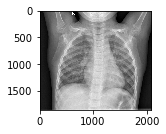

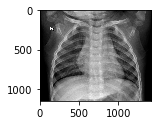

In [4]:
from PIL import Image
# ! pip install imageio
import imageio

for i in range(0,2):
    pic= train_nor_dir[i]
    pic = imageio.imread('chest_xray/train/NORMAL/' + pic)
    plt.figure(figsize = (2,2))
    plt.imshow(pic, cmap='gray')
    print()
    print('Type of the image : ' , type(pic))
    print('Shape of the image : {}'.format(pic.shape))
    print('Dimension of Image {}'.format(pic.ndim))
    print('dtype: ', pic.dtype)
    print('Maximum RGB value in this image {}'.format(pic.max()))
    print('Minimum RGB value in this image {}'.format(pic.min()))

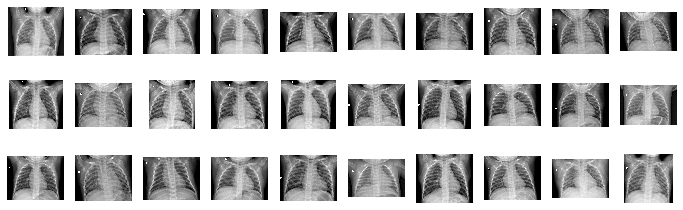

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
n_rows = 3
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        pic= train_nor_dir[index]
        pic = imageio.imread('chest_xray/train/NORMAL/' + pic)
        plt.imshow(pic, cmap='gray')
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# plt.save_fig('ChestImages')
plt.show()

# Import and preprocessing the data

In [6]:
#https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(37)
tf.random.set_seed(89)
with tf.device('/CPU:0'):
    def data_preprocessing_f(img_dims, batch_size, depth):
        """
        img_dims = target_size of the output image (width, height)
        depth: in this problem, we use 1 : greyscale, or 3: for red green blue scale
        """
        if depth ==1 : 
            color_mode="grayscale" 
        else:
            color_mode="rgb"
        
        train_gen = ImageDataGenerator(rescale=1/255.0, zoom_range=0.3, vertical_flip=True, validation_split=0.2)
    #     val_gen = ImageDataGenerator(rescale=1/255.0)
        test_gen = ImageDataGenerator(rescale=1/255.0)

        train_generator = train_gen.flow_from_directory(
            directory=r"chest_xray/train/",
            target_size=(img_dims, img_dims),
            color_mode = color_mode,
            batch_size=batch_size,
            class_mode="binary",  # sinec we are working witn binary (normal-pernumonia) problem
            shuffle=True,
            subset='training')
    #     
        valid_generator = train_gen.flow_from_directory(
            directory=r"chest_xray/train/",
            target_size=(img_dims, img_dims),
            color_mode = color_mode,
            batch_size=batch_size,
            class_mode="binary",
            shuffle=True, 
            subset='validation')
    #     
        test_generator = test_gen.flow_from_directory(
            directory=r"chest_xray/test/",
            target_size=(img_dims, img_dims),
            color_mode= color_mode,
            batch_size=batch_size,  #need to set this to 1 for test set
            class_mode='binary',  
            shuffle=False)
        return(train_generator, valid_generator, test_generator)


In [7]:
#--------------------------------------------
# Call the function to import the data
img_dims = 150
batch_size = 16
train_generator, valid_generator, test_generator = data_preprocessing_f(img_dims, batch_size, 3)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Frequency of the normal+infected: 
             normal  pnuemonia
train         1073       3100
validation     268        775
test           234        390


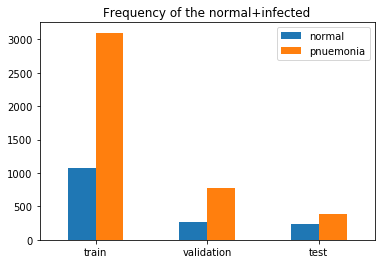

In [8]:
from collections import Counter

# A function to summarize distribution of tran, validation, test sets generated by ImageDataGenerator flow_from_directory
def sum_dat_create_f(train_generator, valid_generator, test_generator):

    train_counter = list(Counter(train_generator.classes).values())
    val_counter   = list(Counter(valid_generator.classes).values())
    test_counter  = list(Counter(test_generator.classes).values())

    summa_dat = pd.DataFrame([train_counter, val_counter, test_counter], columns=('normal', 'pnuemonia'), index = ['train', 'validation', 'test'])
    print('Frequency of the normal+infected: \n', summa_dat)
    summa_dat.plot(kind='bar', title='Frequency of the normal+infected')
    plt.xticks(rotation=0, horizontalalignment="center")
# Call the function
sum_dat_create_f(train_generator, valid_generator, test_generator)

# Tuning hyper parameter

In [9]:
from tensorflow.keras.callbacks import TensorBoard
# import time
# name= "Chest_Image_Full_tune_{}".format(int(time.time()))
# tensorboard_cb = TensorBoard(log_dir = 'logs./{}'.format(name))


# root_logdir = os.path.join(os.curdir, "logs")

# def get_run_logdir():
#     import time
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_01_16-11_28_43'
# tensorboard_cb = run_logdir

In [10]:

#https://keras-team.github.io/keras-tuner/
from kerastuner.tuners import RandomSearch
seed = 240
np.random.seed(seed)
tf.random.set_seed(seed)

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
secs = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

In [11]:



# A function to build models with some different options for tuning hyper-parameter
# This function create multiple options for models with different values for hyper-parametr and compile models
with tf.device('GPU:0'):
    def build_model(hp):
        """hp: stands for hyper-parameters"""
        model = keras.Sequential()

        model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=[img_dims, img_dims, 3]))
        model.add(BatchNormalization()) # use Batch Normalization to address the vanishing/exploding gradients problems
        model.add(MaxPool2D(pool_size=(2, 2)))

        for i in range(hp.Int("Conv Layers", min_value=0, max_value=2)):
            model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [64,128,256]), 3, activation='relu', padding='same'))
        model.add(keras.layers.MaxPool2D(2,2))
        model.add(keras.layers.Dropout(0.5))

        for i in range(hp.Int("Conv Layers", min_value=0, max_value=2)):
            model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [64,128,256]), 3, activation='relu', padding='same'))
        model.add(keras.layers.MaxPool2D(2,2))
        model.add(keras.layers.Dropout(0.5))

        # Flatten            
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(hp.Choice("Dense layer", [128, 256, 256]), activation='relu'))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        # Compile
        model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        return model

    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=20,
    )
    
    path = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

    tuner.search(train_generator, 
                 steps_per_epoch=train_generator.samples//batch_size, 
                 validation_data=valid_generator,
                 epochs=20, 
                 batch_size=batch_size, 
                 callbacks=[tensorboard_callback])


Trial 20 Complete [00h 42m 03s]
val_accuracy: 0.9587727785110474

Best val_accuracy So Far: 0.9587727785110474
Total elapsed time: 12h 46m 41s
INFO:tensorflow:Oracle triggered exit


In [12]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [13]:
best_model = tuner.get_best_models()[0]
best_model.save('./best_model')

INFO:tensorflow:Assets written to: ./best_model\assets


In [14]:
best_model_withcallback = keras.models.load_model('./best_model')
best_model_evaluate = best_model.evaluate(test_generator, 
                                     steps = test_generator.n//batch_size)
print(best_model_evaluate)

39/39 [==============================] - 16s 392ms/step - loss: 0.4852 - accuracy: 0.8674
[0.3162696361541748, 0.9086538553237915]


In [15]:
best_model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       18560     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 256)       0

In [17]:
from sklearn.metrics import confusion_matrix

def evaluate_predictions_f(model, generator, threshold):
    """
    model: a cnn 
    generator: test_generator, we will predict and evaluate the accuracy on this
    threshold: in (0,1) a threshold used for cnn with output layer activation=sigmoid
    """
    y_true = generator.classes[generator.index_array]
    y_pred = model.predict(x=generator, batch_size = batch_size)
    y_predClass = np.array(y_pred > threshold,dtype='int32')

    con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_predClass).numpy()
    print('Accuracy: ', np.trace(con_mat)/np.sum(con_mat), '\n')
    #Normalization Confusion Matrix to the interpretation of which class is being misclassified.
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm, index= ['Normal', 'Pneumonia'], columns=['Normal', 'Pneumonia'] )
    return(con_mat_df)
# 
# Call the evaluate_prediction_f to print the confusion matrix

con_mat_best_model = evaluate_predictions_f(best_model, test_generator, 0.5)
print('Normalized confusion matrix of model 2 \n', con_mat_best_model)

Accuracy:  0.9086538461538461 

Normalized confusion matrix of model 2 
            Normal  Pneumonia
Normal       0.79       0.21
Pneumonia    0.02       0.98
